In [54]:

import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from collections import Counter 
import re
from scipy import stats
import numpy as np
from sklearn import linear_model
#from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss

In [2]:
# Createa new column of the total count of text features for each row
def convert_dt_numeric(dataframe):
    datetime_float = []
    dct = {}
    indexes = list(dataframe.index.values.tolist())
    text_features_count = []

    for index in indexes:
        # counting total # of features
        if 'features' in dataframe:
            values = list(dataframe['features'][index])
            text_features_count.append(len(values))

        # converting time to float
        if 'created' in dataframe:
            datetime_obj = datetime.strptime(dataframe['created'][index], '%Y-%m-%d %H:%M:%S') 
            datetime_sec = time.mktime(datetime_obj.timetuple())
            datetime_float.append(datetime_sec)
    #     Convert float to datetime obj
    #     datetime_obj_after = datetime.fromtimestamp(datetime_sec) 
    #     print(datetime_obj, "=>", datetime_sec, "=>", datetime_obj_after)
    #     print(type(datetime_sec)) // float
    # dct
    if 'features' in dataframe:
        dataframe['text_features_count'] = text_features_count
    if 'created' in dataframe:
        dataframe['datetime_float'] = datetime_float

    # label interest_level => row : 2, medium : 1, high : 0
    if 'interest_level' in dataframe:
        lb_make = LabelEncoder()
        dataframe["interest_level_code"] = lb_make.fit_transform(dataframe["interest_level"])

    # Count total # of photos for each listing
    if 'photos' in dataframe:
        dataframe['num_photos'] = dataframe['photos'].apply(len)
    if 'bathrooms' and 'bedrooms' in dataframe:
        dataframe['total_rooms'] = dataframe['bathrooms'] + dataframe['bedrooms']

## Remove Outliers, Missing Data, and Irrelevent Features

In [3]:
df2 = pd.read_json("./data/train.json")
# df2.head(1)
# df2.info()
test_json = pd.read_json("./data/test.json")
test_json.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street


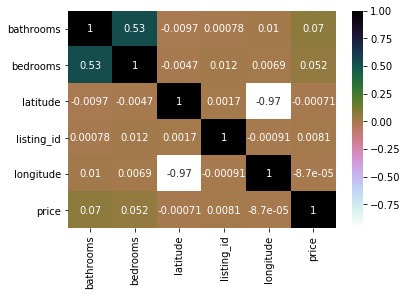

In [4]:
#plt.figure(figsize=(7,4))
sns.heatmap(df2.corr(), annot=True, cmap='cubehelix_r')
#plt.show()
# bathrooms and bedrooms are correlated - 0.53
# longitude and latitude are uncorrelated
# bathrooms and price are correlated - 0.07
# bedrooms and price are correlated - 0.052

In [5]:
# Remove Outliers and Drop Empty Fields
newdf2 = df2[(df2['description'] != '') & (df2['description'] != '<p><a  website_redacted')]
newdf2 = newdf2[newdf2['display_address'] != '']
newdf2 = newdf2[newdf2['features'].str.len() > 0]
newdf2 = newdf2[(newdf2['interest_level'] == 'low') | (newdf2['interest_level'] == 'medium') | (newdf2['interest_level'] == 'high')]
newdf2 = newdf2[(newdf2['price'] != 10) & (newdf2['price'] != 0)]
newdf2 = newdf2[newdf2['latitude'] != 0]
newdf2 = newdf2[newdf2['longitude'] != 0]
# newdf2 = newdf2[newdf2['photos'].str.len() > 0]
newdf2 = newdf2[newdf2['street_address'].str.len() > 0]

newdf2 = newdf2[(np.abs(stats.zscore(newdf2['bathrooms'])) < 3)]
newdf2 = newdf2[(np.abs(stats.zscore(newdf2['bedrooms'])) < 3)]
newdf2 = newdf2[(np.abs(stats.zscore(newdf2['latitude'])) < 3)]
newdf2 = newdf2[(np.abs(stats.zscore(newdf2['longitude'])) < 3)]
newdf2 = newdf2[(np.abs(stats.zscore(newdf2['price'])) < 3)]

In [6]:
# indexes = list(newdf2.index.values.tolist())
# values = list(newdf2['price'][indexes])
    
# plt.scatter(indexes, df2['price'][indexes], edgecolor = 'black')
# plt.xlabel('indexes')
# plt.ylabel('Number of Bedrooms')
# plt.show()
# newdf2['price'].describe()

In [7]:
# newdf2['features'].head(5)

In [8]:
# show {index # : {# of features : [list of features]}
# dct = {}
# indexes = list(newdf2.index.values.tolist())
# for index in indexes:
#     values = list(newdf2['features'][index])
#     feature_info = {}
#     feature_count = len(values)
# #     print(values)
#     dct[index] = feature_info
#     feature_info[feature_count] = values
# dct

In [9]:
# Createa new column of the total count of text features for each row
dct = {}
indexes = list(newdf2.index.values.tolist())
text_features_count = []
for index in indexes:
    values = list(newdf2['features'][index])
    text_features_count.append(len(values))
# dct

newdf2['text_features_count'] = text_features_count
# newdf2.head(8)

In [10]:
# label interest_level = row : 2
# label interest_level = medium : 1
# label interest_level = high : 0
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
newdf2["interest_level_code"] = lb_make.fit_transform(newdf2["interest_level"])


# newdf2.head(1)

In [11]:
import time
from datetime import datetime

indexes = list(newdf2.index.values.tolist())
datetime_float = []
for index in indexes:
    datetime_obj = datetime.strptime(newdf2['created'][index], '%Y-%m-%d %H:%M:%S') 
    datetime_sec = time.mktime(datetime_obj.timetuple())
    datetime_float.append(datetime_sec)
#     Convert float to datetime obj
#     datetime_obj_after = datetime.fromtimestamp(datetime_sec) 
#     print(datetime_obj, "=>", datetime_sec, "=>", datetime_obj_after)
#     print(type(datetime_sec)) // float
newdf2['datetime_float'] = datetime_float
#newdf2.head(2)


In [12]:
indexes = list(test_json.index.values.tolist())
datetime_float = []
for index in indexes:
    datetime_obj = datetime.strptime(test_json['created'][index], '%Y-%m-%d %H:%M:%S') 
    datetime_sec = time.mktime(datetime_obj.timetuple())
    datetime_float.append(datetime_sec)
#     Convert float to datetime obj
#     datetime_obj_after = datetime.fromtimestamp(datetime_sec) 
#     print(datetime_obj, "=>", datetime_sec, "=>", datetime_obj_after)
#     print(type(datetime_sec)) // float
test_json['datetime_float'] = datetime_float
#newdf2.head(2)

In [13]:
lrdf = newdf2
lrdf['num_photos'] = lrdf['photos'].apply(len)
lrdf['created'] = pd.to_datetime(lrdf['created'])
lrdf['hour'] = lrdf['created'].dt.hour
#lrdf.dtypes

#lrdf = lrdf.drop(columns=['interest_level', 'building_id', 'created', 'description', 'display_address', 'features', 'latitude', 'listing_id', 'longitude', 'manager_id', 'photos', 'street_address'])
lrdf = lrdf.drop(columns=['interest_level', 'building_id', 'description', 'created', 'display_address', 'features', 'datetime_float', 'listing_id', 'manager_id', 'photos', 'street_address'])

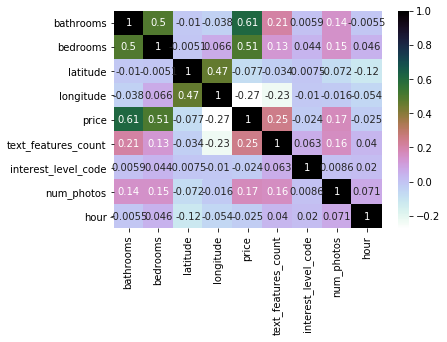

In [14]:
lrdf.head(1)
sns.heatmap(lrdf.corr(), annot=True, cmap='cubehelix_r')


## Logistic Regression Iterations

In [15]:
y = lrdf['interest_level_code']
X = lrdf.drop(columns=['interest_level_code'])

#X_alt = X.drop(columns=['text_features_count', 'datetime_float', 'num_photos'])
X_alt = X.drop(columns=['text_features_count', 'num_photos', 'latitude', 'longitude', 'hour'])

#X_alt['bath_bed'] = X_alt['bathrooms'] + X_alt['bedrooms']

#X_alt = X_alt.drop(columns=['bathrooms', 'bedrooms', 'hour'])

y.shape, X.shape
X_alt.head(1)
#sns.heatmap(X_alt.corr(), annot=True, cmap='cubehelix_r')


,bathrooms,bedrooms,price
10000,1.0,2,5465


## Create Scores

In [61]:
# create model
#model = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
#model = linear_model.LogisticRegression(multi_class='multinomial', solver='saga', max_iter=250, penalty='l1', warm_start=True)
model = linear_model.LogisticRegression(multi_class='auto') #multi_class='multinomial', solver='newton-cg' )

scores = []
cv = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)
kf = KFold(n_splits=5, shuffle=False)
for train_index, test_index in kf.split(X, y):
   
    X_train, X_test = X[train_index[0]:train_index[-1]], X[test_index[0]:test_index[-1]]
    y_train, y_test = y[train_index[0]:train_index[-1]], y[test_index[0]:test_index[-1]]
    model.fit(X_train, np.ravel(y_train))
    scores.append(model.score(X_test, y_test))
    
#scores = cross_val_score(model, X, np.ravel(y), cv=5)
print("Accuracy first iteration:", round(np.mean(scores), 6), "+/-", round(np.std(scores)*2, 6))


# try second model
scores2 = []
kf = KFold(n_splits=10, shuffle=True)
#model2 = linear_model.LogisticRegression(multi_class='multinomial', max_iter=150, solver='saga', penalty='l1') #, class_weight='balanced', warm_start=True)
#cv = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)

model2 = linear_model.LogisticRegression(multi_class='multinomial', max_iter=150, solver='saga', penalty='l1', C=0.001, class_weight='balanced', warm_start=True) #, class_weight='balanced', warm_start=True)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

for train_index, test_index in kf.split(X_alt, y):
   
    X_train, X_test = X_alt[train_index[0]:train_index[-1]], X_alt[test_index[0]:test_index[-1]]
    y_train, y_test = y[train_index[0]:train_index[-1]], y[test_index[0]:test_index[-1]]
    model.fit(X_train, y_train)
    scores2.append(model.score(X_test, y_test))
#scores2 = cross_val_score(model2, X_alt, np.ravel(y), cv=cv)
print("Accuracy second iteration:", round(np.mean(scores2), 6), "+/-", round(np.std(scores2)*2, 6))


('Accuracy first iteration:', 0.681189, '+/-', 0.012175)
('Accuracy second iteration:', 0.682355, '+/-', 4e-05)


## Convert Test.json to use with model

In [17]:
#test_json.head(1)
test_df = test_json[['bathrooms', 'bedrooms', 'created', 'latitude', 'longitude', 'price', 'datetime_float']]
convert_dt_numeric(test_df)
#test_df['bath_bed'] = test_df['bathrooms'] + test_df['bedrooms']
test_df = test_df.drop(columns=['latitude', 'longitude'])


test_df['created'] = pd.to_datetime(test_df['created'])
test_df['hour'] = test_df['created'].dt.hour
test_df = test_df.drop(columns=['created', 'datetime_float', 'total_rooms', 'hour'])

test_df.head(1)

/home/kainoa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kainoa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,bathrooms,bedrooms,price
0,1.0,1,2950


### Generate Predictions to Upload to kaggle

In [18]:
#for train_index, test_index in kf.split(initial_train_X):
#model2.fit(X_alt, y)
#probs = model2.predict_proba(test_df)
#output = test_json['listing_id']

In [19]:
model2.fit(X_alt, y)
predicted = model2.predict(test_df) 
probs_labels = model2.predict_proba(test_df) # output: [[p1,p2,p3],[p1,p2,p3]...]

df_with_ps = test_json.copy(deep=True)
df_with_ps['p_0_interest'] = [probs[0] for probs in probs_labels]
df_with_ps['p_1_interest'] = [probs[1] for probs in probs_labels]
df_with_ps['p_2_interest'] = [probs[2] for probs in probs_labels]
df_with_ps['predicted'] = predicted

df_with_ps.rename(columns={'p_0_interest': 'high', 'p_1_interest': 'medium', 'p_2_interest': 'low'}, inplace=True)
df2csv = df_with_ps[['listing_id', 'high', 'medium','low']]
df2csv.to_csv('kaggle-test-Stratified_5FoldCV_improved_C_0001_G_SCALE.csv', encoding='utf-8', index=False)

/home/kainoa/.local/lib/python2.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### Confusion Matrix

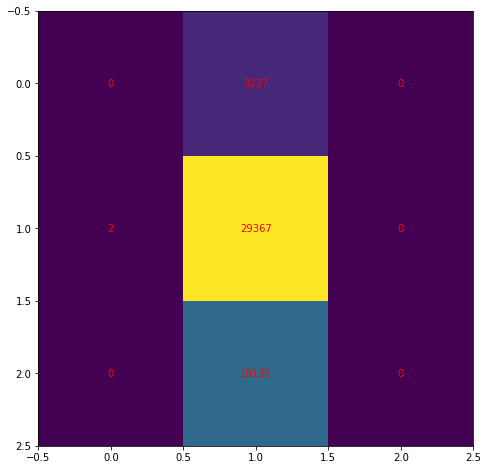

In [52]:
#model2.fit(X_alt, y)
cm = confusion_matrix(y_test, model2.predict(X_test))
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(cm)
ax.grid(False)
#ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
#ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
#ax.set_ylim(1.5, -0.5)
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
#plt.show()
plt.savefig('matrix.png')

## Classification report

In [29]:
print(classification_report(y, model2.predict(X_alt)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3228
           1       0.69      1.00      0.81     29379
           2       0.00      0.00      0.00     10138

   micro avg       0.69      0.69      0.69     42745
   macro avg       0.23      0.33      0.27     42745
weighted avg       0.47      0.69      0.56     42745



/home/kainoa/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Logloss 

In [60]:
#model2.fit(X_alt, y)
prob = model2.predict_proba(X_alt)
predict_list = log_loss(y, prob)
predict_list

1.0140440106403859